# PDE-FIND for Burger's Equation

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on Burger's equation with an added diffusive term.
$$
u_t + uu_x = u_{xx}
$$
The solution given is a single travelling wave, starting out as a Gaussian.

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = sio.loadmat('../Datasets/burgers.mat')
u = real(data['usol'])
x = real(data['x'][0])
t = real(data['t'][:,0])
dt = t[1]-t[0]
dx = x[2]-x[1]

Text(0.5, 0, 't')

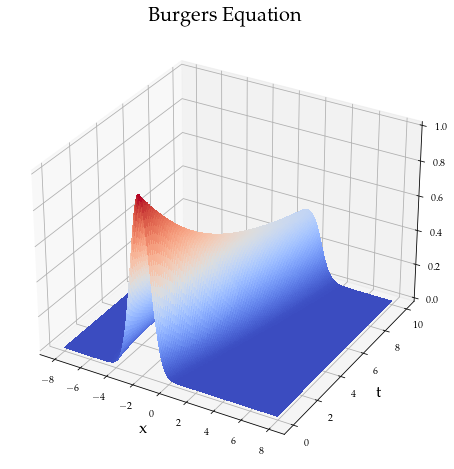

In [3]:
X, T = np.meshgrid(x, t)
fig1 = figure()
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title('Burgers Equation', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)

## Construct $\Theta (U)$ and compute $U_t$

The function build_linear_system does this for us.  We specify <br>
D = highest derivative to appear in $\Theta$  <br>
P = highest degree polynomial of $u$ to appear in $\Theta$ (not including multiplication by a derivative.  <br>
time_diff and space_diff taken via finite differences

Printed out is a list of candidate functions for the PDE.  Each is a column of $\Theta (U)$

In [4]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}']

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [5]:
# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-1.000403 +0.000000i)uu_{x}
    + (0.100145 +0.000000i)u_{xx}
   


In [6]:
err = abs(np.array([(1 -  1.000987)*100, (.1 - 0.100220)*100/0.1]))
print("Error using PDE-FIND to identify Burger's equation:\n")
print("Mean parameter error:", mean(err), '%')
print("Standard deviation of parameter error:", std(err), '%')

Error using PDE-FIND to identify Burger's equation:

Mean parameter error: 0.15935000000000255 %
Standard deviation of parameter error: 0.06064999999999543 %


## Now identify the same dynamics but with added noise.

The only difference from above is that finite differences work poorly for noisy data so here we use polynomial interpolation.  With deg_x or deg_t and width_x or width_t we specify the degree number of points used to fit the polynomials used for differentiating x or t.  Unfortunately, the result can be sensitive to these.

In [7]:
numpy.random.seed(0)
un = u + 0.01*std(u)*np.random.randn(u.shape[0],u.shape[1])

In [8]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)

In [9]:
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-1.007779 +0.000000i)uu_{x}
    + (0.103338 +0.000000i)u_{xx}
   


In [10]:
err = abs(np.array([(1 -  1.009655)*100, (.1 - 0.102966)*100/0.1]))
print("Error using PDE-FIND to identify Burger's equation with added noise:\n")
print("Mean parameter error:", mean(err), '%')
print("Standard deviation of parameter error:", std(err), '%')

Error using PDE-FIND to identify Burger's equation with added noise:

Mean parameter error: 1.9657499999999966 %
Standard deviation of parameter error: 1.0002499999999996 %
